# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

#Are squirrels who climb more often more likely to approach humans? (linear regression?)
#Which location has squirrels that are most likely to approach humans? (clustering , N,S,E,W)

data = pd.read_csv("2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20250418.csv")
print("Hello World!")

# Strip any leading/trailing spaces from column names
data.columns = data.columns.str.strip()

# Now you should be able to access columns like this:
print(data.columns)  # Check to confirm exact names


Hello World!
Index(['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift', 'Date',
       'Hectare Squirrel Number', 'Age', 'Primary Fur Color',
       'Highlight Fur Color', 'Combination of Primary and Highlight Color',
       'Color notes', 'Location', 'Above Ground Sighter Measurement',
       'Specific Location', 'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Other Activities', 'Kuks', 'Quaas', 'Moans', 'Tail flags',
       'Tail twitches', 'Approaches', 'Indifferent', 'Runs from',
       'Other Interactions', 'Lat/Long'],
      dtype='object')


              precision    recall  f1-score   support

       Black       0.00      0.00      0.00        30
    Cinnamon       0.00      0.00      0.00        76
        Gray       0.82      1.00      0.90       488

    accuracy                           0.82       594
   macro avg       0.27      0.33      0.30       594
weighted avg       0.67      0.82      0.74       594



C:\Users\Infer\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


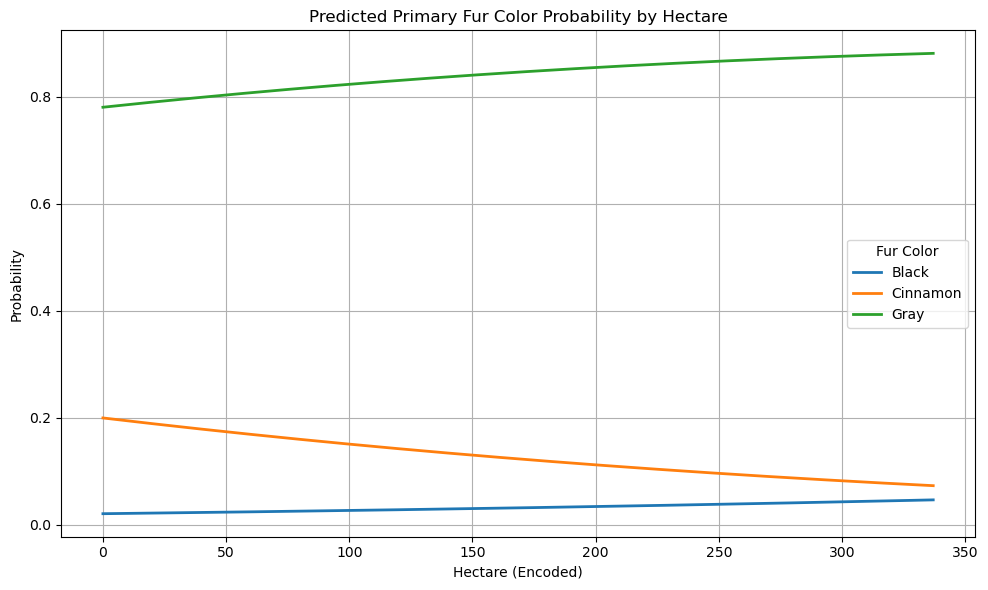

In [83]:
##Does elevation impact the secondary fur color of squirrels? (Logistic regression) (predict squirle 2nd hair color)
import pandas as pd


# Strip column names
data.columns = data.columns.str.strip()

# Drop rows missing key data
data = data.dropna(subset=['Primary Fur Color', 'Hectare'])

# Encode Hectare
hectare_le = LabelEncoder()
data['Hectare_Label'] = hectare_le.fit_transform(data['Hectare'])

# Encode Fur Color
fur_le = LabelEncoder()
data['Fur_Color_Label'] = fur_le.fit_transform(data['Primary Fur Color'])

# Features and target
x = data[['Hectare_Label']]
y = data['Fur_Color_Label']

# Split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Logistic regression
model = LogisticRegression()
model.fit(x_train, y_train)

# Evaluate
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred, target_names=fur_le.classes_, zero_division=0))

#pyplot plotting for testing
#get the x range (fix this for labeling later?)
x_range = np.arange(data['Hectare_Label'].min(), data['Hectare_Label'].max() + 1).reshape(-1, 1)

#get fur color probability
probs = model.predict_proba(x_range)

plt.figure(figsize=(10, 6))
for i, color in enumerate(fur_le.classes_):
    plt.plot(x_range, probs[:, i], label=color, linewidth=2)

plt.title("Predicted Primary Fur Color Probability by Hectare")
plt.xlabel("Hectare (Encoded)")
plt.ylabel("Probability")
#plt.xticks(x_range.flatten(), hectare_le.inverse_transform(x_range.flatten()), rotation=90)
plt.legend(title='Fur Color')
plt.grid(True)
plt.tight_layout()
plt.show()


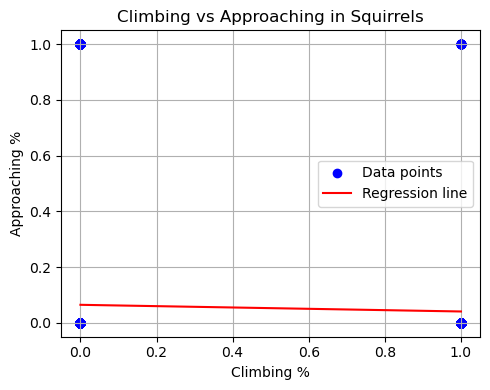

Equation [[-0.02394667]] x + [0.06457167]
R² Score: 0.00


In [84]:
#Climbing Squirrles (linear regression. Climb amount (# of times observed climbing) vs chance to approach humans)


#group by squirrel id
grouped = data.groupby("Unique Squirrel ID").agg({
    'Climbing' : 'mean', #gives the mean of all squirrel data values (% times the squirrel was seen climbing).
    'Approaches' : 'mean', #gives % times squirrel approaches
}).reset_index()

#rename so I actually know what they are
grouped.rename(columns={'Climbing': 'Climb_Percent', 'Approaches': 'Approach_Percent'}, inplace=True)

x = grouped[['Climb_Percent']].values
y = grouped[['Approach_Percent']].values

model = LinearRegression()
model.fit(x,y)

# Predict y values for regression line
x_range = np.linspace(0, 1, 100).reshape(-1, 1)
y_pred = model.predict(x_range)

# Plotting
plt.figure(figsize=(5, 4))
plt.scatter(x, y, color='blue', label='Data points')
plt.plot(x_range, y_pred, color='red', label='Regression line')
plt.title('Climbing vs Approaching in Squirrels')
plt.xlabel('Climbing %')
plt.ylabel('Approaching %')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Equation", model.coef_, "x", "+", model.intercept_)

# Print regression details
print(f"R² Score: {model.score(x, y):.2f}")
#print(f"Intercept: {model.intercept_:.2f}")
#print(f"Slope: {model.coef_[0]:.2f}")


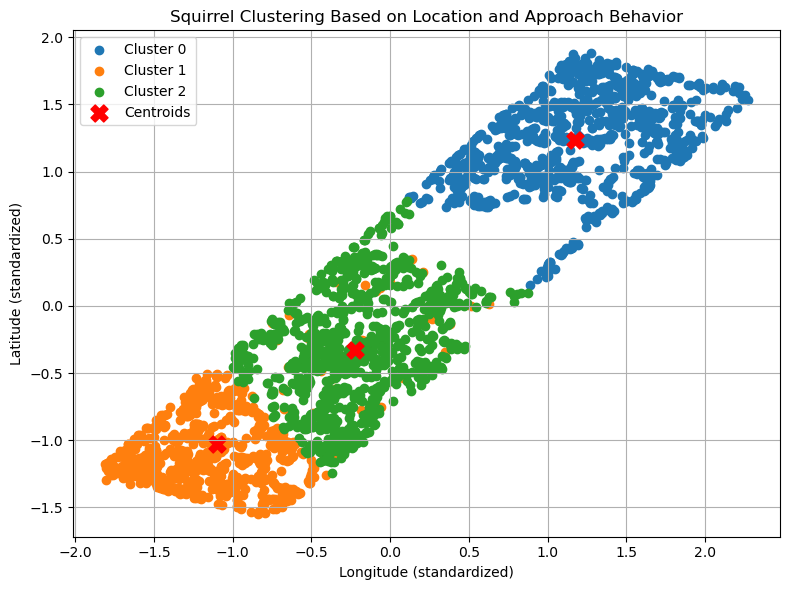

In [85]:
#Location

center_lat = 40.783875
center_lon = -73.9690349

#gets the compass direction for latitude and longitude
def get_direction(row):
    ns = 'North' if row['Y'] > center_lat else 'South'
    ew = 'West' if row['X'] > center_lon else 'East'
    return f"{ns}-{ew}"


data['Direction'] = data.apply(get_direction, axis=1)


# Filter for squirrels with location and approach info
data = data.dropna(subset=['Approaches', 'X', 'Y'])

# Features: latitude (X), longitude (Y), and Approaches as 1/0
data['Approach_Int'] = data['Approaches'].astype(int)
features = data[['X', 'Y', 'Approach_Int']]


# Standardize features
x_std = StandardScaler().fit_transform(features)

# Set number of clusters
k = 3
km = KMeans(n_clusters=k, random_state=42).fit(x_std)

# Get centroids and labels
centroids = km.cluster_centers_
labels = km.labels_

# Plot
plt.figure(figsize=(8, 6))
for i in range(k):
    cluster = x_std[labels == i]
    plt.scatter(cluster[:, 0], cluster[:, 1], label=f'Cluster {i}')

# Plot centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='X', s=150, c='red', label='Centroids')

# Labels and formatting
plt.xlabel("Longitude (standardized)")
plt.ylabel("Latitude (standardized)")
plt.title("Squirrel Clustering Based on Location and Approach Behavior")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

